# Importer les librairies

In [91]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvr
from scipy.stats import pearsonr as pr
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score 

# Les données

## Les données de diabetes 

In [59]:
df_diabetes=pd.read_csv("./data/diabetes.csv")
df_diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [60]:
df_diabetes["Outcome"].unique()

array([1, 0], dtype=int64)

In [61]:
df_diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## Les données de Iris

In [62]:
df_iris=pd.read_csv("./data/iris.csv")
df_iris.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [63]:
df_iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


In [64]:
df_iris.describe()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,75.500000,5.843333,3.054000,3.758667,1.198667
std,43.445368,0.828066,0.433594,1.764420,0.763161
min,1.000000,4.300000,2.000000,1.000000,0.100000
25%,38.250000,5.100000,2.800000,1.600000,0.300000
50%,75.500000,5.800000,3.000000,4.350000,1.300000
75%,112.750000,6.400000,3.300000,5.100000,1.800000
max,150.000000,7.900000,4.400000,6.900000,2.500000


# La construction du modèle de Naive Bayes

In [159]:
# Création d'une classe contenant les méthodes fit, predict et scores en respectant le théorème de Bayes :
class NaiveBayes:
    # Pour vérifier que fit est appellée avant predict 
    fitted = False
    # Pour vérifier s'il ya des labels 'négatives' 
    present = False
    
    def fit(self, X, y, var_smoothing=1e-9): # ajouter un 'smoothing parameter' pour calculer la stabilité
        
        #  créer un dictionnaire pour les paramètres de la distribution de vraissemblance
        self.params = {}
        
        # La distribution des priors :
        self.priors = {}
        
        # Pour obtenir les ensembles de classes dans la target de la variable y :
        self.classes = list(sorted(set(y)))
        
        if -1 in self.classes:
            self.present = True
            
        
        for indx, c in enumerate(self.classes):
            
            # Estimer les paramètres de la distributions de vraissemblance
            x = X[y==c]
            self.params[indx] = {
                'mean': x.mean(axis=0),
                'variance': x.var(axis=0) + var_smoothing }  
            
            # Calculer la distributions des priors 
            self.priors[indx]=len(y[y==c])/len(y)
            
            self.fitted = True
            
            
    def predict(self, X):
        
        # Déclenche une exception si la fonction est appellé avant fit dans le modèle 
        if not self.fitted:
            raise Exception('The modèle doit être entrainer avant !')
        
        # enregister la valeur de n_rows dans  X:
        n = X.shape[0]
        
        #  enregister le nombre de classes à partir du train
        k = len(self.params)
        
        # initialiser la  matrice pour la distribution à posteriori  (n*k)
        P = np.zeros((n, k), dtype = 'float')
        
        #  calculer la probabilité à posteriori  qui est proportionnel à vraissemblance max * priors
        for indx, prm in self.params.items():
            
            mean, var = prm['mean'], prm['variance']
            
            # ajouter dans la matrice par colonnes 
            P[:,indx] = mvr.pdf(X, mean = mean, cov = var)* self.priors[indx]
        
        # retourner le label(column number) avec la plus grande valeure à posteriori
        out = np.argmax(P, axis=1)
        
        if self.present:
            out[out == 0] = -1
            
        return out
    
                                
    def score(self, X, y):
        
        #predire les classes
        y_pred = self.predict(X)
        
        #retourner la moyenne avec les objets corretement labellés
        return np.mean(y_pred == y)
    
    
    def  confusion_matrix_plot(self, X, y):
        
        #predire les classes
        y_pred = self.predict(X)
        #calculer la matrice de confusion
        cm = confusion_matrix(y, y_pred)
        
        # transformer cm de array à dataframe
        column = [str(x) for x in self.classes]
        df_cm = pd.DataFrame(cm, index = column, columns = column)
        sn.set(font_scale=1.4) # for label size
        sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
        # show the matrix
        plt.show()


## Validation du modèle avec les données de diabète 

In [160]:
#Pour les données de diabetes : 
y=df_diabetes["Outcome"]
X=df_diabetes.copy()
del X["Outcome"]


In [161]:
#Splitter les données 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [162]:
#Créer et entrainer le model de NB :
NB = NaiveBayes()
NB.fit(X_train, y_train)
score=NB.score(X_test, y_test)
score

0.7662337662337663

In [163]:
y_pred=NB.predict(X_test)
Precision=precision_score(y_test,y_pred)
Precision

0.6610169491525424

In [164]:
recall=recall_score(y_test, y_pred)
recall

0.7090909090909091

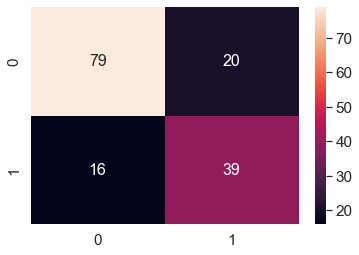

In [165]:
# Matrice de Confusion :
NB.confusion_matrix_plot(X_test, y_test)

In [175]:
def validation_croise(model, X, y, cv=5):
    fold_shape=X.shape[0]//cv
    Xfolds=[]
    yfolds=[]
    for i in range(cv):
        Xfolds.append(X[i*fold_shape:(i+1)*fold_shape])
        yfolds.append(y[i*fold_shape:(i+1)*fold_shape])
    scores=[]
    for i in range(cv):
        #prendre le fold de validation
        X_val=Xfolds[i]
        y_val=yfolds[i]
        #construire les données d'entrainement 
        X_train=Xfolds.copy()
        X_train=np.concatenate((X_train[0], X_train[1], X_train[2], X_train[3]), axis=0)
        #print(X_train.shape)
        y_train=yfolds.copy()
        #y_train.remove(y_val)
        y_train=np.concatenate((y_train[0], y_train[1], y_train[2], y_train[3]), axis=0)
        #print(y_train.shape)
        #entrainer le modèle : 
        model.fit(X_train,y_train)
        score=model.score(X_val, y_val)
        scores.append(score)
    return scores

In [176]:
NB1=NaiveBayes()
scores=validation_croise(NB1, X, y, cv=5)
print("scores=",np.array(scores))
print("moyenne des scores=",np.array(scores).mean())

scores= [0.75163399 0.73202614 0.75816993 0.83006536 0.75163399]
moyenne des scores= 0.7647058823529412


## Validation du modèle sur les données de IRIS 

In [177]:
#Numéroter les classes :
terms=[(c, n) for (n, c) in enumerate(list(df_iris["Species"].unique()))]
specie_classes=dict(terms)

In [178]:
new_df_iris=df_iris.copy()
for sp in specie_classes.keys():
    new_df_iris.loc[new_df_iris.Species==sp,"Species"]=specie_classes[sp]
new_df_iris.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,0
1,2,4.9,3.0,1.4,0.2,0
2,3,4.7,3.2,1.3,0.2,0
3,4,4.6,3.1,1.5,0.2,0
4,5,5.0,3.6,1.4,0.2,0


In [179]:
#Pour les données de Iris : 
y=new_df_iris["Species"]
X=new_df_iris.copy()
del X["Species"]

In [180]:
#Splitter les données 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [181]:
#Créer et entrainer le model de NB :
NB = NaiveBayes()
NB.fit(X_train, y_train, var_smoothing=1e-5)
score=NB.score(X_test, y_test)
score

1.0

In [183]:
y_pred=NB.predict(X_test)

In [186]:
NB1=NaiveBayes()
scores=validation_croise(NB1, X, y, cv=5)
print("scores",scores)
print("moyennes des scores",np.array(scores).mean())

scores [1.0, 1.0, 1.0, 0.9666666666666667, 0.7666666666666667]
moyennes des scores 0.9466666666666667


# Construire le modèle de TAN 

In [128]:
# Algorithme de Kruskal pour la construction de l'étendue maximale de l'arbre
class Graph:

    #construire un graphe
    def __init__(self, vertices):
        self.V = vertices
        self.graph = []

    def add_edge(self, u, v, w):
        self.graph.append([u, v, w])

    # Fonction de recherche
    def find(self, parent, i):
        if parent[i] == i:
            return i
        return self.find(parent, parent[i])

    def apply_union(self, parent, rank, x, y):
        xroot = self.find(parent, x)
        yroot = self.find(parent, y)
        if rank[xroot] < rank[yroot]:
            parent[xroot] = yroot
        elif rank[xroot] > rank[yroot]:
            parent[yroot] = xroot
        else:
            parent[yroot] = xroot
            rank[xroot] += 1

    #  Appliquer l'algorithme de Kruskal 
    def kruskal_algo(self):
        result = []
        i, edge = 0, 0
        self.graph = sorted(self.graph, key=lambda item: item[2], reverse = True)
        parent = []
        rank = []
        for node in range(self.V):
            parent.append(node)
            rank.append(0)
        while edge < self.V - 1:
            u, v, w = self.graph[i]
            i = i +1
            x = self.find(parent, u)
            y = self.find(parent, v)
            if x != y:
                edge += 1
                result.append([u, v, w])
                self.apply_union(parent, rank, x, y)
        return result

In [133]:
class TAN:
    
    #  Pour vérifier que fit est appéllée avant predict 
    fitted = False
   
    def fit(self, X, y, var_smoothing=1e-9): #  ajouter a 'smoothing parameter' pour calculer la stabilité 
        
        # La distribution des priors 
        self.priors = {}

        # créer un dictionnaire pour l'information mutuelle 
        self.mu_info = {}
        
        #Obtenir l'ensemble des classes dans la variable cible y 
        self.classes = list(sorted(set(y)))
        
        for c in self.classes:
            # appliquer le conditionnement au label
            x = X[y==c]
            # calculer la distribution des priors
            self.mu_info[c] = {}
            self.priors[c] = len(y[y==c])/len(y)

            for i in range(X.shape[1]):
                for j in range(i+1, X.shape[1]):
                    self.mu_info[c][str(i)+str(j)] =  -0.5*np.log(1-pr(x[:,i], x[:,j])[0])
            
        # repalcer lrs valeurs manquantes nan avec 0
        self.mu_info = {k1: {k2: 0 if np.isnan(v2) else v2 for k2, v2 in v1.items()} \
                    for k1, v1 in self.mu_info.items()}

        # en ayant les informations mutuelles, on peut construire les 10 arbres avec l'algorithme de Kruskal
        self.Trees = []
        for c in self.classes:
          # creer autant de  noeuds autant de features dans le training set
          g = graph(X.shape[1])

          #creer l'arbre associé avec le label c
          for k, v_ in self.mu_info[c].items():
            # pour avoir les indices des featuresto de l'information mutuelle get the indexes of features the mutual info to hava a suitable
            # pour avoir un argument approprié à la fonction: add_graph method
            u, v, w = int(k.split(",")[0]), int(k.split(",")[1]), v_

          # ajouter chaque  structure d'arbre à une liste d'arbres
          self.Trees.append(g.kruskal_algo())

In [134]:
tan=TAN()
tan.fit(X_train,y_train)

TypeError: '(slice(None, None, None), 0)' is an invalid key